In [1]:
import os, cv2
import random
import numpy as np
import tensorflow as tf
from matplotlib import pyplot as plt
from keras.preprocessing.image import ImageDataGenerator
from scipy.signal.windows import gaussian
from skimage.segmentation import slic,mark_boundaries
from skimage.util import img_as_float
from sklearn import svm
from scipy.ndimage import uniform_filter
from skimage.measure import label, regionprops
from skimage.transform import hough_ellipse
from skimage.draw import ellipse_perimeter
from sklearn.metrics import jaccard_score

clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(10,10))
# Use the updated function
loss = tf.compat.v1.losses.sparse_softmax_cross_entropy

In [24]:
img_height = 224
img_width = 224
batch_size = 32

datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    zoom_range=0.15,
    horizontal_flip=True,
)

base_dirs = {
    'train': r'datasets\real_combined_last_dataset\train'
}

# Construct absolute paths by joining with the base directory 'miniproject-2'
base_dirs_full = {key: os.path.abspath(os.path.join('E:\\study material\\miniproject-2', value)) for key, value in base_dirs.items()}
print(base_dirs_full)

# Check existence of directories
for key, value in base_dirs_full.items():
    print(f"{key}: {value} -> Exists: {os.path.exists(value)}")


{'train': 'E:\\study material\\miniproject-2\\datasets\\real_combined_last_dataset\\train'}
train: E:\study material\miniproject-2\datasets\real_combined_last_dataset\train -> Exists: True


In [25]:
def data_generator(directory):
    return datagen.flow_from_directory(
        directory,
        target_size=(img_height, img_width),
        batch_size=32,
        class_mode='binary',  # Update to 'categorical' for classification or 'input' for segmentation
        shuffle=False,  # Set to True if you want to shuffle the data
        seed=42
    )

train_ds = data_generator(base_dirs['train'])

Found 6070 images belonging to 2 classes.


In [26]:
def preprocess_image(image_path, target_size=(224, 224)):
    image = cv2.imread(image_path)

    # Apply Gaussian smoothing
    image = cv2.GaussianBlur(image, (5, 5), 0)

    # Split the image into B,G,R channels
    B, G, R = cv2.split(image)

    # Apply histogram equalization to each channel
    B_equ = cv2.equalizeHist(B)
    G_equ = cv2.equalizeHist(G)
    R_equ = cv2.equalizeHist(R)

    # Merge the channels back together
    equ = cv2.merge((B_equ, G_equ, R_equ))

    # Resize the image
    equ = cv2.resize(equ, target_size)

    # Normalize pixel values
    equ = equ / 255.0

    return equ


In [27]:
def superpixel(image):
    # Convert the image into floating point representation
    image = img_as_float(image)
    # Apply SLIC and extract (approximately) the supplied number of segments
    segments = slic(image, n_segments = 100, sigma = 5)
    # Show the output of SLIC
    fig = plt.figure("Superpixels")
    ax = fig.add_subplot(1, 1, 1)
    ax.imshow(mark_boundaries(image, segments))
    plt.axis("off")
    return segments

In [30]:
def segment(image, plot_seg, plot_hist):
    # Pre-processing and Smoothing
    image = image.astype('uint8')
    Abo, Ago, Aro = cv2.split(image)
    Aro = clahe.apply(Aro)
    Ago = Ago.astype('uint8')
    Ago = clahe.apply(Ago)
    # Gaussian Window for smoothing
    M = 60
    filter = gaussian(M, std=6)
    filter = filter / sum(filter)
    STDf = filter.std()

    # Preprocessing Red and Green Channels
    Ar = Aro - Aro.mean() - Aro.std()
    Mr = Ar.mean()
    SDr = Ar.std()
    #print("Mean Ar:", Ar.mean())
    #print("Std Dev Ar:", Ar.std())
    Thr = Ar.mean() - 0.5 * Ar.std()  # Adjust as needed
    #Thr = 0.5 * M - STDf - Ar.std()
    #print("THR",Thr)
    Ag = Ago - Ago.mean() - Ago.std()
    Mg = Ag.mean()
    SDg = Ag.std()
    Thg = 0.5 * Mg + 2 * STDf + 2 * SDg + Mg
    #print("Thg",Thg)
    # Histogram Calculation
    hist, bins = np.histogram(Ag.ravel(), 256, [0, 256])
    histr, binsr = np.histogram(Ar.ravel(), 256, [0, 256])

    # Histogram Smoothing
    smooth_hist_g = np.convolve(filter, hist)
    smooth_hist_r = np.convolve(filter, histr)

    if plot_hist:
        plt.subplot(2, 2, 1)
        plt.plot(hist)
        plt.title("Preprocessed Green Channel")
        plt.subplot(2, 2, 2)
        plt.plot(smooth_hist_g)
        plt.title("Smoothed Histogram Green Channel")
        plt.subplot(2, 2, 3)
        plt.plot(histr)
        plt.title("Preprocessed Red Channel")
        plt.subplot(2, 2, 4)
        plt.plot(smooth_hist_r)
        plt.title("Smoothed Histogram Red Channel")
        plt.show()
    Ar = Ar.astype('uint8')
    Ag = Ag.astype('uint8')
    # Binary decision maps for Optic Disk and Optic Cup
    _, Dd = cv2.threshold(Ar, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    _, Dc = cv2.threshold(Ag, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    cv2.imwrite('miniproject-2\datasets\Cups_discs\disk.png',Dd)
    plt.imsave('miniproject-2\datasets\Cups_discs\cup.png',Dc)

    if plot_seg:
        plt.subplot(2, 2, 1)
        plt.imshow(Dd, cmap='gray')
        plt.axis("off")
        plt.title("Optic Disk")
        plt.subplot(2, 2, 2)
        plt.imshow(Dc, cmap='gray')
        plt.axis("off")
        plt.title("Optic Cup")
        plt.show()


    return Dd, Dc

In [69]:
import math
def active_segmentation(Image,disc):
    Abo,Ago,Aro = cv2.split(Image)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    #Aro = clahe.apply(Aro)
    Ago =Ago.astype('uint8')
    Ago = clahe.apply(Ago)
    Ag = Ago - Ago.mean()           #Preprocessing Green
    Ag = Ag - Ag.mean() - Ago.std()
    height, width = Ag.shape[:2]
    crop_top = int(0.45 * height)   
    crop_bottom = int(0.65 * height)  
    crop_left = int(0.35 * width)    
    crop_right = int(0.65 * width)  
    Ag = Ag[crop_top:crop_bottom, crop_left:crop_right]

    filter = gaussian(99, std=6) #Gaussian Window
    filter=filter/sum(filter)
    hist,bins = np.histogram(Aro.ravel(),256,[0,256])   
    smooth_hist_ro=np.convolve(filter,hist)
    histb,binsb = np.histogram(Aro.ravel(),256,[0,256])   
    smooth_hist_bo=np.convolve(filter,histb)

    if (disc == 1): 
        image = Aro
    else:
        Abo =Abo.astype("uint8")
        Abo = clahe.apply(Abo)
        Ab = Abo - Abo.mean()           
        Ab = Ab - Ab.mean() - Abo.std()
        image = Ab
    img=np.array(image,dtype=np.float64) 
    IniLSF = np.ones((img.shape[0],img.shape[1]),img.dtype) 
    IniLSF[30:80,30:80]= -1 
    IniLSF=-IniLSF 
    Image = Image.astype('uint8')
    Image = cv2.cvtColor(Image,cv2.COLOR_BGR2RGB) 
    if (disc == 1):
        print('Working on disc...')
    else:
        print('Working on cup...')
    def mat_math (intput,str):
        output=intput 
        for i in range(img.shape[0]):
            for j in range(img.shape[1]):
                if str=="atan":
                    output[i,j] = math.atan(intput[i,j]) 
                if str=="sqrt":
                    output[i,j] = math.sqrt(intput[i,j]) 
        return output 
    def CV (LSF, img, mu, nu, epison,step):

        Drc = (epison / math.pi) / (epison*epison+ LSF*LSF)
        Hea = 0.5*(1 + (2 / math.pi)*mat_math(LSF/epison,"atan")) 
        Iy, Ix = np.gradient(LSF) 
        s = mat_math(Ix*Ix+Iy*Iy,"sqrt") 
        Nx = Ix / (s+0.000001) 
        Ny = Iy / (s+0.000001) 
        Mxx,Nxx =np.gradient(Nx) 
        Nyy,Myy =np.gradient(Ny) 
        cur = Nxx + Nyy 
        Length = nu*Drc*cur 

        Lap = cv2.Laplacian(LSF,-1) 
        Penalty = mu*(Lap - cur) 

        s1=Hea*img 
        s2=(1-Hea)*img 
        s3=1-Hea 
        C1 = s1.sum()/ Hea.sum() 
        C2 = s2.sum()/ s3.sum() 
        CVterm = Drc*(-1 * (img - C1)*(img - C1) + 1 * (img - C2)*(img - C2)) 

        LSF = LSF + step*(Length + Penalty + CVterm) 
        #plt.imshow(s, cmap ='gray'),plt.show() 
        return LSF 

    mu = 1.5 
    nu = 0.03 * 255 * 255 
    num = 50
    epison = 1 
    step = 0.1 
    LSF=IniLSF 
    for i in range(1,num):
        LSF = CV(LSF, img, mu, nu, epison,step) #迭代
        if (i == num-1):
            if(disc == 1):
                plt.imsave('adisc.png', LSF)
            else:
                plt.imsave('acup.png', LSF)

In [31]:
def cdr(cup, disc, plot):
    # Convert cup and disc images to uint8 type
    cup = cup.astype('uint8')
    disc = disc.astype('uint8')
    
    # Morphological operations on cup
    R1 = cv2.morphologyEx(cup, cv2.MORPH_CLOSE, cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(2,2)), iterations = 1)
    r1 = cv2.morphologyEx(R1, cv2.MORPH_OPEN, cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(7,7)), iterations = 1)
    R2 = cv2.morphologyEx(r1, cv2.MORPH_CLOSE, cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(1,21)), iterations = 1)
    r2 = cv2.morphologyEx(R2, cv2.MORPH_OPEN, cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(21,1)), iterations = 1)
    R3 = cv2.morphologyEx(r2, cv2.MORPH_CLOSE, cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(33,33)), iterations = 1)	
    r3 = cv2.morphologyEx(R3, cv2.MORPH_OPEN, cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(43,43)), iterations = 1)

    img = clahe.apply(r3)
    
    # Find contours in cup
    ret, thresh = cv2.threshold(cup, 127, 255, 0)
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cup_diameter = 0
    
    if contours:
        largest_area = 0
        el_cup = contours[0]
        for i in range(len(contours)):
            if len(contours[i]) >= 5:
                area = cv2.contourArea(contours[i])
                if area > largest_area:
                    largest_area = area
                    el_cup = cv2.fitEllipse(contours[i])
    
        cv2.ellipse(img, el_cup, (140, 60, 150), 3)
        x, y, w, h = cv2.boundingRect(contours[0])
        cup_diameter = max(w, h)
        
    # Morphological operations on disc
    R1 = cv2.morphologyEx(disc, cv2.MORPH_CLOSE, cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(2,2)), iterations = 1)
    r1 = cv2.morphologyEx(R1, cv2.MORPH_OPEN, cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(7,7)), iterations = 1)
    R2 = cv2.morphologyEx(r1, cv2.MORPH_CLOSE, cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(1,21)), iterations = 1)
    r2 = cv2.morphologyEx(R2, cv2.MORPH_OPEN, cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(21,1)), iterations = 1)
    R3 = cv2.morphologyEx(r2, cv2.MORPH_CLOSE, cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(33,33)), iterations = 1)
    r3 = cv2.morphologyEx(R3, cv2.MORPH_OPEN, cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(43,43)), iterations = 1)

    img2 = clahe.apply(r3)
    
    # Find contours in disc
    ret, thresh = cv2.threshold(disc, 127, 255, 0)
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    disk_diameter = 0
    
    if contours:
        largest_area = 0
        el_disc = contours[0]
        for i in range(len(contours)):
            if len(contours[i]) >= 5:
                area = cv2.contourArea(contours[i])
                if area > largest_area:
                    largest_area = area
                    el_disc = cv2.fitEllipse(contours[i])
        
        cv2.ellipse(img2, el_disc, (140, 60, 150), 3)
        x, y, w, h = cv2.boundingRect(contours[0])
        disk_diameter = max(w, h)

    
    if plot:
        plt.subplot(2,2,1)
        plt.imshow(img2, interpolation='bicubic')
        plt.axis("off")
        plt.title("Optic Disk ")
        plt.subplot(2,2,2)
        plt.imshow(img)
        plt.axis("off")
        plt.title("Optic Cup ")
        plt.show()
        
    if disk_diameter == 0:
        return 1
    
    cdr = cup_diameter \ disk_diameter #cup_diameter / disk_diameter
    return cdr


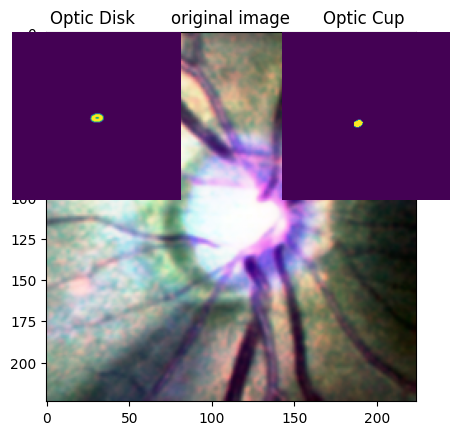

Text(0.5, 1.0, 'clahe red')

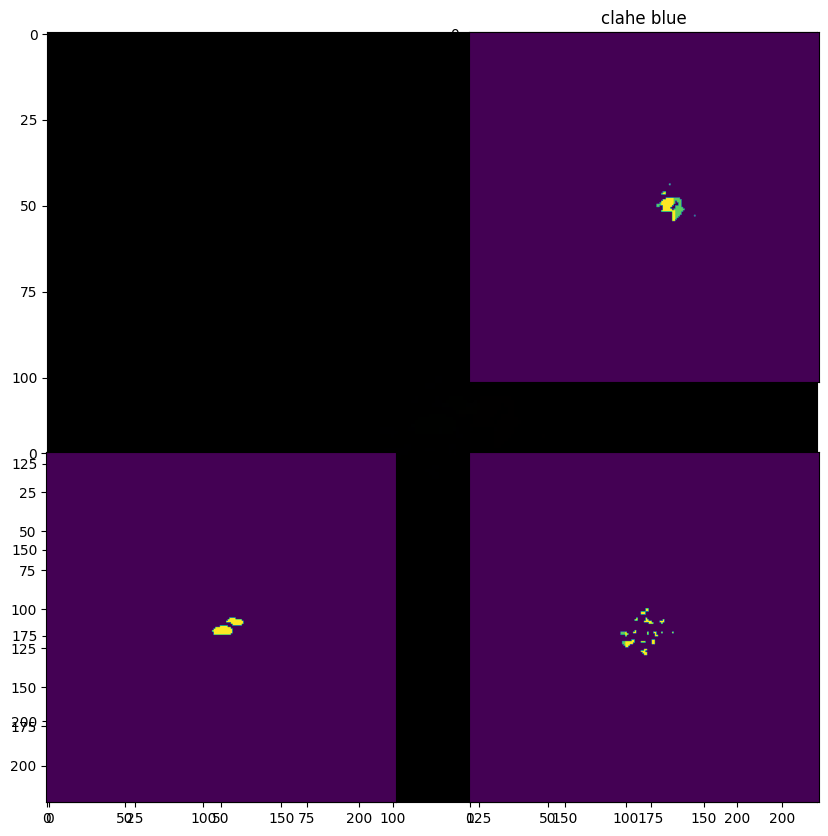

In [81]:
image_path =  "datasets\\real_combined_last_dataset\\train\\glaucoma\\1.png"
image = preprocess_image(image_path)
plt.imshow(image)
plt.title("original image")
image = image.astype('uint8')
#print ("befor",image.shape)
Abo,Ago,Aro = cv2.split(image)
#print("After",image.shape)
#segment(image , True ,True)
C,D = segment(image , False , False)
#print("After1",image.shape)
cdr_cal = cdr(C,D,True)
plt.figure(figsize=(10,10))
plt.plot()
plt.imshow(image)
Abo = Abo.astype('uint8')
Abo = clahe.apply(Abo)
plt.subplot(2, 2, 2)
plt.imshow(Abo)
plt.title('clahe blue')
Ago = Ago.astype('uint8')
Ago = clahe.apply(Ago)
plt.subplot(2, 2, 3)
plt.imshow(Ago)
plt.title('clahe green')
Aro = Aro.astype('uint8')
Aro = clahe.apply(Aro)
plt.subplot(2, 2, 4)
plt.imshow(Aro)
plt.title('clahe red')


In [33]:
import os
import pandas as pd

def process_images(base_dirs):
    all_data = []
    processed_filenames = set()  # Keep track of processed filenames
    batch_size = 32

    categories = ['glaucoma', 'normal']

    for category in categories:
        category_dir = os.path.join(base_dirs['train'], category)
        images = [os.path.join(category_dir, img) for img in os.listdir(category_dir)]

        for image_path in images:
            try:
                image = preprocess_image(image_path)
                cup, disc = segment(image, False, False)
                cdr_cal = cdr(cup, disc, False)

                # Get label based on category
                category_label = 1 if category == 'glaucoma' else 0

                # Check if the filename has been processed before printing
                if image_path not in processed_filenames:
                    print(f"{image_path} is processed with category {category} and label {category_label}")
                    processed_filenames.add(image_path)

                # Append data to the list
                all_data.append({
                    'filename': str(image_path),  # Convert to string explicitly
                    'label': category_label,
                    'cdr': cdr_cal
                })
            except Exception as e:
                print(f"Error processing image {image_path}")
                print(f"Error message: {str(e)}")

    # Create DataFrame
    df = pd.DataFrame(all_data)

    # Save DataFrame to CSV
    output_directory = r'E:\study material\miniproject-2\datasets\Cups_discs\files'
    os.makedirs(output_directory, exist_ok=True)
    output_file_path = os.path.join(output_directory, 'full.csv')
    df.to_csv(output_file_path, index=False)

    return df

# Example usage
base_dirs = {
    'train': r'datasets\real_combined_last_dataset\train'
}
df = process_images(base_dirs)


datasets\real_combined_last_dataset\train\glaucoma\069.jpg is processed with category glaucoma and label 1
datasets\real_combined_last_dataset\train\glaucoma\072.jpg is processed with category glaucoma and label 1
datasets\real_combined_last_dataset\train\glaucoma\086.jpg is processed with category glaucoma and label 1
datasets\real_combined_last_dataset\train\glaucoma\087.jpg is processed with category glaucoma and label 1
datasets\real_combined_last_dataset\train\glaucoma\094.jpg is processed with category glaucoma and label 1
datasets\real_combined_last_dataset\train\glaucoma\097.jpg is processed with category glaucoma and label 1
datasets\real_combined_last_dataset\train\glaucoma\1.png is processed with category glaucoma and label 1
datasets\real_combined_last_dataset\train\glaucoma\10.png is processed with category glaucoma and label 1
datasets\real_combined_last_dataset\train\glaucoma\100.png is processed with category glaucoma and label 1
datasets\real_combined_last_dataset\trai

In [36]:
X_train = pd.DataFrame(df['cdr'])
Y_train = pd.DataFrame(df['label'])

In [56]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import accuracy_score, confusion_matrix

In [57]:
regressor = LinearRegression()
regressor.fit(X_train, Y_train)
x_train, x_test, y_train, y_test = train_test_split(X_train, Y_train, test_size=0.2, random_state=0)

In [58]:
print(regressor.intercept_)

[0.7512028]


In [60]:
y_pred = regressor.predict(x_test)
y_pred = np.round(y_pred)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

# Calculate confusion matrix

Accuracy: 0.7444168734491315
Confusion matrix:
[[  0 309]
 [  0 900]]


In [61]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix

# Assuming df contains 'cdr' and 'label' columns

# Extract features and labels
X = df[['cdr']]
y = df['label']

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# RandomForestClassifier
rf_classifier = RandomForestClassifier(random_state=0)
rf_classifier.fit(X_train, y_train)

# Predictions on the test set
rf_predictions = rf_classifier.predict(X_test)

# Evaluate RandomForestClassifier
rf_accuracy = accuracy_score(y_test, rf_predictions)
rf_confusion_matrix = confusion_matrix(y_test, rf_predictions)

print("RandomForestClassifier:")
print(f"Accuracy: {rf_accuracy}")
print("Confusion matrix:")
print(rf_confusion_matrix)

# Support Vector Machine (SVM)
svm_classifier = SVC(random_state=0)
svm_classifier.fit(X_train, y_train)

# Predictions on the test set
svm_predictions = svm_classifier.predict(X_test)

# Evaluate SVM
svm_accuracy = accuracy_score(y_test, svm_predictions)
svm_confusion_matrix = confusion_matrix(y_test, svm_predictions)

print("\nSupport Vector Machine (SVM):")
print(f"Accuracy: {svm_accuracy}")
print("Confusion matrix:")
print(svm_confusion_matrix)


RandomForestClassifier:
Accuracy: 0.7419354838709677
Confusion matrix:
[[  5 304]
 [  8 892]]

Support Vector Machine (SVM):
Accuracy: 0.7435897435897436
Confusion matrix:
[[  0 309]
 [  1 899]]


In [64]:
def process(base_dirs):
    all_data = []
    processed_filenames = set()  # Keep track of processed filenames
    batch_size = 32

    categories = ['glaucoma', 'normal']
    count = 0  # Initialize count
    for category in categories:
        category_dir = os.path.join(base_dirs['train'], category)
        images = [os.path.join(category_dir, img) for img in os.listdir(category_dir)]

        for image_path in images:
            # Assuming category_label is defined somewhere in your code
            image = preprocess_image(image_path)
            active_segmentation(image, 1)
            cup, disc = segment(image, False, False)
            cdr_cal = cdr(cup, disc, False)
            print(f"{image_path} is processed in {category} and CDR: {cdr_cal}")
            
            # Convert the NumPy array to a string representation
            image_path_str = str(image_path)
            
            # Check if the filename has been processed before printing
            if image_path_str not in processed_filenames:
                print(f"{image_path_str} is processed in {category} and CDR: {cdr_cal}")
                processed_filenames.add(image_path_str)
            
            count += 1

    return all_data

df = process(base_dirs)

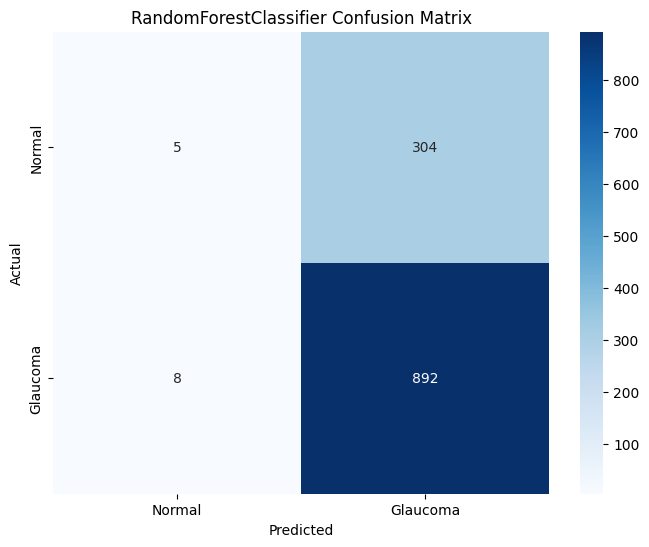

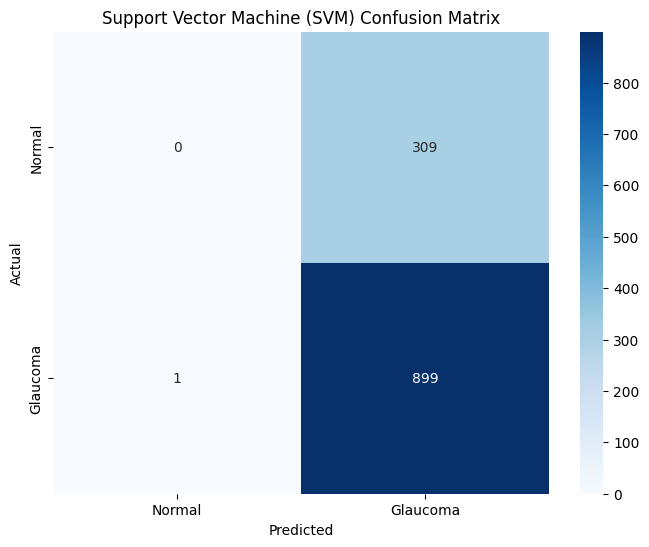

In [75]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Plot RandomForestClassifier confusion matrix
rf_predictions = rf_classifier.predict(X_test)
rf_confusion_matrix = confusion_matrix(y_test, rf_predictions)

plt.figure(figsize=(8, 6))
plt.title("RandomForestClassifier Confusion Matrix")
sns.heatmap(rf_confusion_matrix, annot=True, fmt="d", cmap=plt.cm.Blues, xticklabels=['Normal', 'Glaucoma'], yticklabels=['Normal', 'Glaucoma'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Plot SVM confusion matrix
svm_predictions = svm_classifier.predict(X_test)
svm_confusion_matrix = confusion_matrix(y_test, svm_predictions)

plt.figure(figsize=(8, 6))
plt.title("Support Vector Machine (SVM) Confusion Matrix")
sns.heatmap(svm_confusion_matrix, annot=True, fmt="d", cmap=plt.cm.Blues, xticklabels=['Normal', 'Glaucoma'], yticklabels=['Normal', 'Glaucoma'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


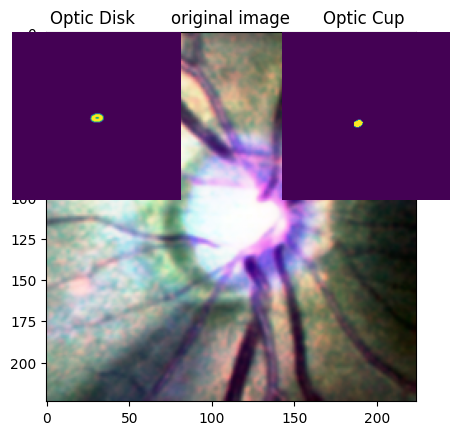

Text(0.5, 1.0, 'clahe red')

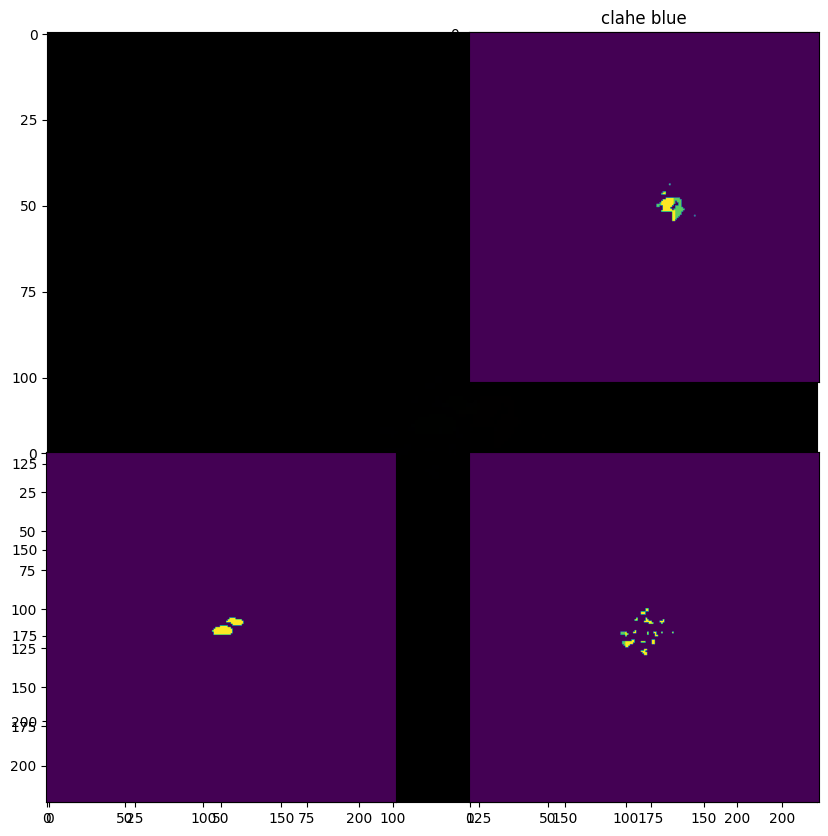

In [82]:
image_path =  "datasets\\real_combined_last_dataset\\train\\glaucoma\\1.png"
image = preprocess_image(image_path)
plt.imshow(image)
plt.title("original image")
image = image.astype('uint8')
#print ("befor",image.shape)
Abo,Ago,Aro = cv2.split(image)
#print("After",image.shape)
#segment(image , True ,True)
C,D = segment(image , False , False)
#print("After1",image.shape)
cdr_cal = cdr(C,D,True)

plt.figure(figsize=(10,10))
plt.plot()
plt.imshow(image)
Abo = Abo.astype('uint8')
Abo = clahe.apply(Abo)
plt.subplot(2, 2, 2)
plt.imshow(Abo)
plt.title('clahe blue')
Ago = Ago.astype('uint8')
Ago = clahe.apply(Ago)
plt.subplot(2, 2, 3)
plt.imshow(Ago)
plt.title('clahe green')
Aro = Aro.astype('uint8')
Aro = clahe.apply(Aro)
plt.subplot(2, 2, 4)
plt.imshow(Aro)
plt.title('clahe red')
